In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

from pyro.nn import AutoRegressiveNN, DenseNN
from pyro.distributions.transforms import NeuralAutoregressive, AffineAutoregressive, AffineCoupling

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "mnist"
args.z_dim = 64
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])
    
    
prior_params = list([])
prior_flow = None

if args.num_flows_prior:
    flows = []
    for i in range(args.num_flows_prior):
        if args.nf_prior == 'IAF':
            one_arn = AutoRegressiveNN(args.z_dim, [2 * args.z_dim]).to(args.device)
            one_flow = AffineAutoregressive(one_arn)
        elif args.nf_prior == 'RNVP':
            hypernet = DenseNN(input_dim=args.z_dim // 2, hidden_dims=[2 * args.z_dim, 2 * args.z_dim],
                    param_dims=[args.z_dim - args.z_dim // 2, args.z_dim - args.z_dim // 2]).to(args.device)
            one_flow = AffineCoupling(args.z_dim // 2, hypernet).to(args.device)
        flows.append(one_flow)
    prior_flow = nn.ModuleList(flows)
    prior_params = list(prior_flow.parameters())

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)

if args.separate_params:
    params_decoder = list(target.parameters())
    params_inference = list(encoder.parameters()) + list(transitions.parameters()) + list(reverse_params) + prior_params
    optimizer_inference = torch.optim.Adam(params=params_inference, lr=args.learning_rate_inference)
    optimizer = torch.optim.Adam(params=params_decoder, lr=args.learning_rate)
else:
    params = list(encoder.parameters()) + list(target.parameters()) + list(transitions.parameters()) + list(reverse_params) + prior_params
    optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
    
optimizer_vanilla = torch.optim.Adam(params=list(encoder.parameters()) + list(target.parameters()) + prior_params, lr=args.learning_rate_vanilla)

In [6]:
if args.vanilla_vae_epoches > 0:
    batch_size = args.train_batch_size
    args.train_batch_size = 100 # just for Vanilla VAE training
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
def get_prior(args, inf_samples, prior_flow):
    if args.nf_prior:
        # Note, that here I am using T^+1 as T^-1
        log_jac_flow = 0.
        prev_v = inf_samples
        for flow_num in range(args.num_flows_prior):
            u = prior_flow[flow_num](prev_v)
            log_jac_flow += prior_flow[flow_num].log_abs_det_jacobian(prev_v, u)
            prev_v = u
        prior = -1. / 2 * torch.sum(u * u, 1) + log_jac_flow
    else:
        prior = -1. / 2 * torch.sum(inf_samples * inf_samples, 1)
    return prior

In [9]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu, all_directions, get_prior, args, prior_flow):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
        
    log_p = target.get_logdensity(z=z_new, x=x, prior=get_prior, args=args, prior_flow=prior_flow) + args.std_normal.log_prob(p_new.sum(1))
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo 

In [10]:
def validate_vae(args, encoder, target, transitions, dataset, get_prior, prior_flow):
    elbo_list = []
    for batch_num, batch_val in enumerate(dataset.next_val_batch()):
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        mu, sigma = encoder(batch_val)
        
        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)

        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u
        
        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]
        p = p_old
        
        for k in range(args.K):
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_val,
                                                    p_old=p, k=cond_vectors[k], target_distr=target, args=args, get_prior=get_prior, prior_flow=prior_flow)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_val,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target, args=args, get_prior=get_prior, prior_flow=prior_flow) # sample a_i -- directions
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        
        elbo_current, _ = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_val, sum_log_alpha=sum_log_alpha,
                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions,
                                      get_prior=get_prior, args=args, prior_flow=prior_flow)
        
        elbo_list.append(elbo_current.cpu().detach().numpy())
    mean_val_elbo = np.mean(elbo_list)
    return mean_val_elbo

  0%|          | 0/1000 [00:00<?, ?it/s]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 2 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.549999987706542 

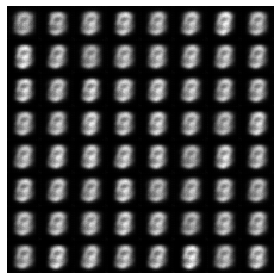

  0%|          | 1/1000 [01:21<22:31:47, 81.19s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 1/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 2 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 2 we have for  0: 0.4499999899417162 

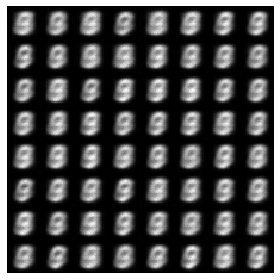

  0%|          | 2/1000 [02:42<22:32:22, 81.31s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 301/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 2 we have for  0: 0.549999987706542 and 

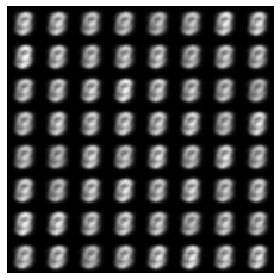

  0%|          | 3/1000 [04:04<22:31:40, 81.34s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 101/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 2 we have for  0: 0.5299999881535769 an

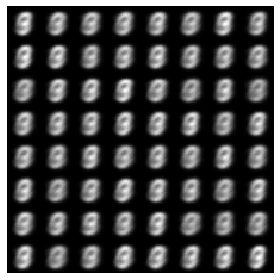

  0%|          | 4/1000 [05:25<22:30:36, 81.36s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 1/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 301/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 401/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 401/590 and on k = 2 we have for  0: 0.5099999886006117 a

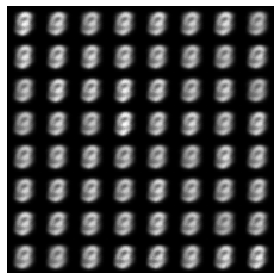

  0%|          | 5/1000 [06:47<22:30:49, 81.46s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 1/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 2 we have for  0: 0.6199999861419201 

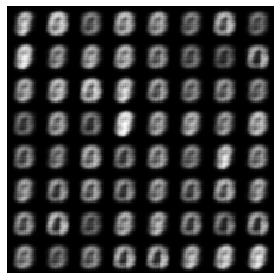

  1%|          | 6/1000 [08:08<22:30:34, 81.52s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 1/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 2 we have for  0: 0.5999999865889549 and 

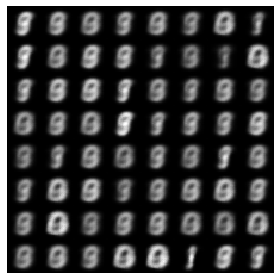

  1%|          | 7/1000 [09:30<22:29:57, 81.57s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 1/590 and on k = 2 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 101/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 401/590 and on k = 2 we have for  0: 0.5599999874830246 

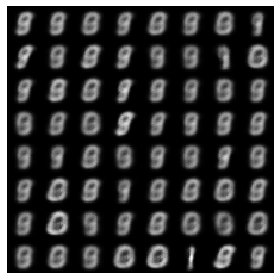

  1%|          | 8/1000 [10:52<22:29:06, 81.60s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 1/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 401/590 and on k = 2 we have for  0: 0.5699999872595072 

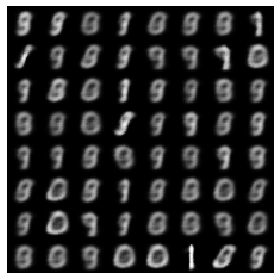

  1%|          | 9/1000 [12:14<22:28:51, 81.67s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 2 we have for  0: 0.5099999886006117 an

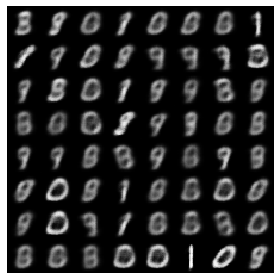

  1%|          | 10/1000 [13:35<22:28:11, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 1/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 201/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 301/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 401/590 and on k = 2 we have for  0: 0.5399999879300594 a

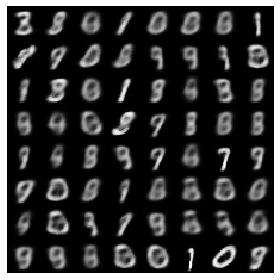

  1%|          | 11/1000 [14:57<22:26:42, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 1/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 2 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 201/590 and on k = 1 we have for  0: 0.7199999839067459 and for +1: 0.2799999937415123
On batch number 201/590 and on k = 2 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 301/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 301/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 401/590 and on k = 2 we have for  0: 0.5899999868124723 and 

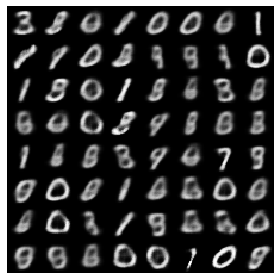

  1%|          | 12/1000 [16:19<22:25:10, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 1/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 201/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 301/590 and on k = 2 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 401/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 2 we have for  0: 0.5699999872595072 and

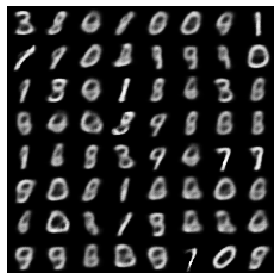

  1%|▏         | 13/1000 [17:41<22:23:56, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 1/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.6799999848008156 and for +1: 0.3199999928474426
On batch number 101/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 2 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 2 we have for  0: 0.5199999883770943 

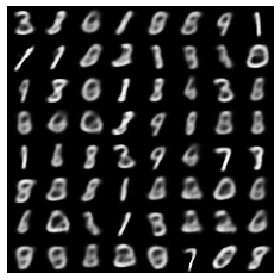

  1%|▏         | 14/1000 [19:02<22:22:23, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 1/590 and on k = 2 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 401/590 and on k = 2 we have for  0: 0.6099999863654375 and f

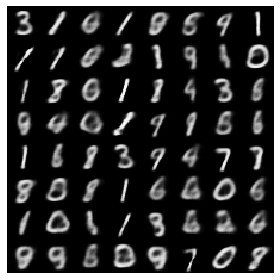

  2%|▏         | 15/1000 [20:24<22:21:00, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 1/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 2 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 301/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 301/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 401/590 and on k = 2 we have for  0: 0.5599999874830246 an

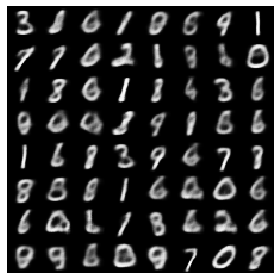

  2%|▏         | 16/1000 [21:46<22:19:42, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 1/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 201/590 and on k = 2 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 301/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 401/590 and on k = 2 we have for  0: 0.6199999861419201 a

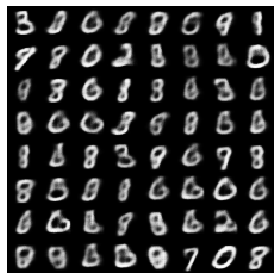

  2%|▏         | 17/1000 [23:07<22:18:33, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 1/590 and on k = 2 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 101/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 201/590 and on k = 2 we have for  0: 0.6799999848008156 and for +1: 0.3199999928474426
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 401/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 401/590 and on k = 2 we have for  0: 0.5399999879300594 an

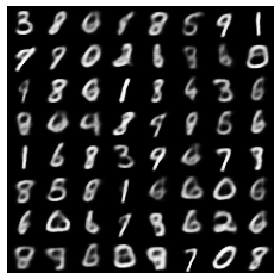

  2%|▏         | 18/1000 [24:29<22:17:38, 81.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 1/590 and on k = 2 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 301/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 301/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 2 we have for  0: 0.6599999852478504 and f

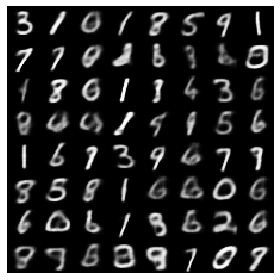

  2%|▏         | 19/1000 [25:51<22:16:40, 81.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 1/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 2 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 401/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 401/590 and on k = 2 we have for  0: 0.5899999868124723 

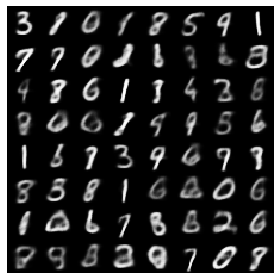

  2%|▏         | 20/1000 [27:13<22:15:29, 81.77s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 1/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 101/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 201/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.6999999843537807 and for +1: 0.29999999329447746
On batch number 301/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 2 we have for  0: 0.5299999881535769 an

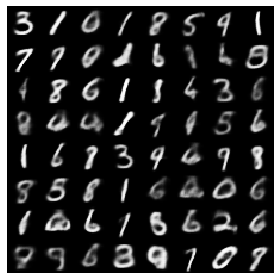

  2%|▏         | 21/1000 [28:34<22:13:45, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 1/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 301/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 401/590 and on k = 2 we have for  0: 0.5099999886006117 and

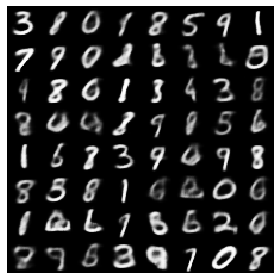

  2%|▏         | 22/1000 [29:56<22:12:23, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 101/590 and on k = 2 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 201/590 and on k = 1 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 201/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 401/590 and on k = 2 we have for  0: 0.6199999861419201 and f

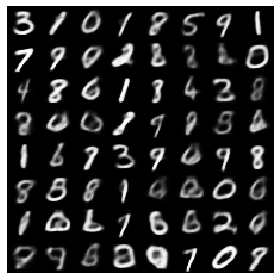

  2%|▏         | 23/1000 [31:18<22:11:11, 81.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 1/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 101/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 201/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 201/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 2 we have for  0: 0.5999999865889549 and

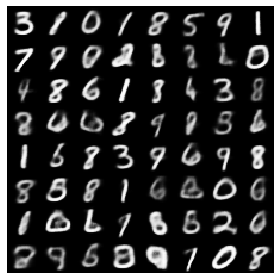

  2%|▏         | 24/1000 [32:40<22:09:14, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 1/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 101/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 401/590 and on k = 1 we have for  0: 0.669999985024333 and for +1: 0.3299999926239252
On batch number 401/590 and on k = 2 we have for  0: 0.4899999890476465 and

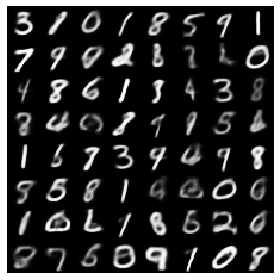

  2%|▎         | 25/1000 [34:01<22:07:35, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 301/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 2 we have for  0: 0.6099999863654375 a

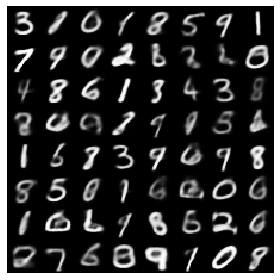

  3%|▎         | 26/1000 [35:23<22:06:10, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 1/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 201/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 201/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 an

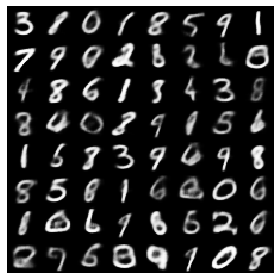

  3%|▎         | 27/1000 [36:45<22:05:12, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 2 we have for  0: 0.6399999856948853 an

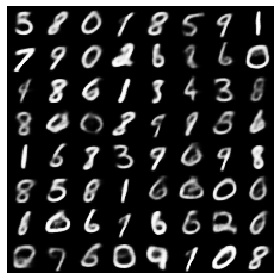

  3%|▎         | 28/1000 [38:06<22:03:33, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 1/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 2 we have for  0: 0.5199999883770943 a

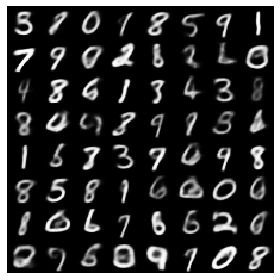

  3%|▎         | 29/1000 [39:28<22:03:06, 81.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 2 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 2 we have for  0: 0.4099999908357858

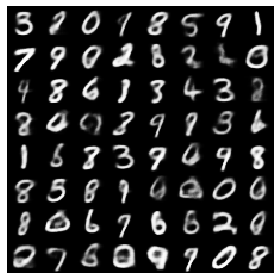

  3%|▎         | 30/1000 [40:50<22:02:29, 81.80s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.4999999888241291 a

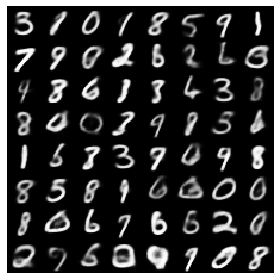

  3%|▎         | 31/1000 [42:12<22:00:36, 81.77s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 201/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 and

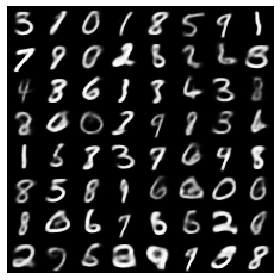

  3%|▎         | 32/1000 [43:33<21:58:43, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 301/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 301/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 2 we have for  0: 0.4999999888241291 and 

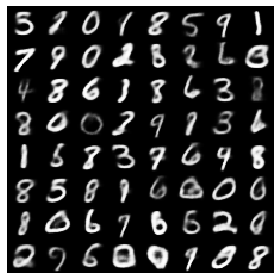

  3%|▎         | 33/1000 [44:55<21:57:09, 81.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 101/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 2 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 an

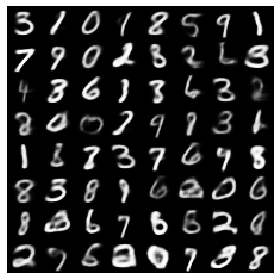

  3%|▎         | 34/1000 [46:17<21:55:29, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 1/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 2 we have for  0: 0.4499999899417162 a

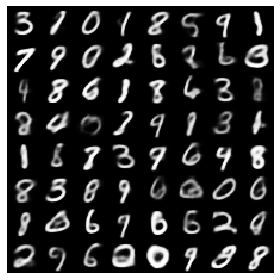

  4%|▎         | 35/1000 [47:38<21:53:48, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 2 we have for  0: 0.5399999879300594 

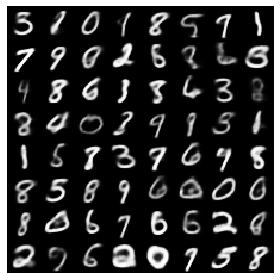

  4%|▎         | 36/1000 [49:00<21:52:29, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 1/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 2 we have for  0: 0.4899999890476465 and

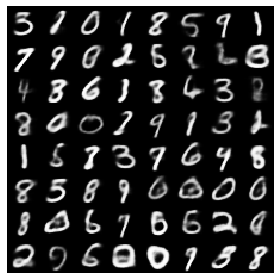

  4%|▎         | 37/1000 [50:22<21:51:22, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 a

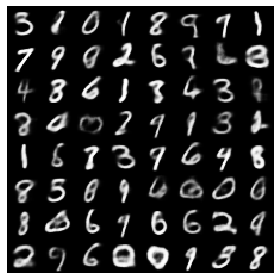

  4%|▍         | 38/1000 [51:44<21:50:03, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 1/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 2 we have for  0: 0.42999999038875103

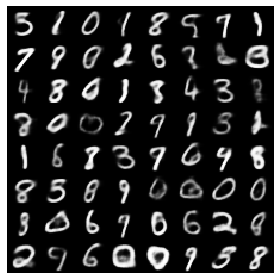

  4%|▍         | 39/1000 [53:05<21:49:13, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.5599999874830246 and

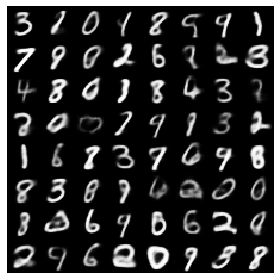

  4%|▍         | 40/1000 [54:27<21:48:10, 81.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 1/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 2 we have for  0: 0.46999998949468136

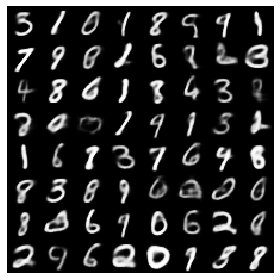

  4%|▍         | 41/1000 [55:49<21:46:24, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 1/590 and on k = 2 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 2 we have for  0: 0.4599999897181988 and fo

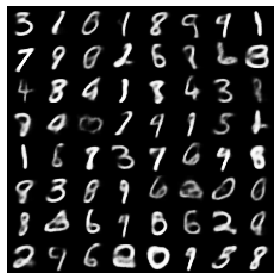

  4%|▍         | 42/1000 [57:11<21:44:41, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 1/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 101/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 2 we have for  0: 0.3899999912828207 and for +1: 0.6099999863654375
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 2 we have for  0: 0.5599999874830246 an

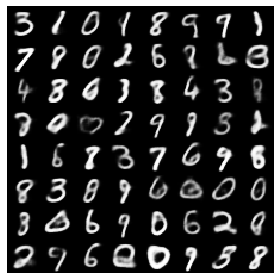

  4%|▍         | 43/1000 [58:32<21:43:08, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 1/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 a

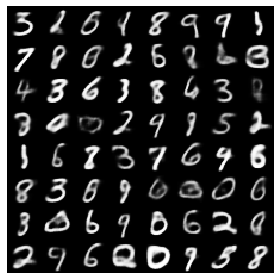

  4%|▍         | 44/1000 [59:54<21:41:52, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 1/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 2 we have for  0: 0.5199999883770943 an

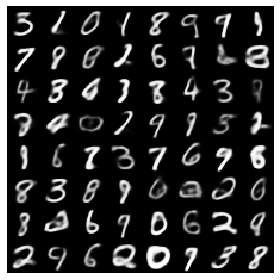

  4%|▍         | 45/1000 [1:01:16<21:40:19, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.5099999886006117 and

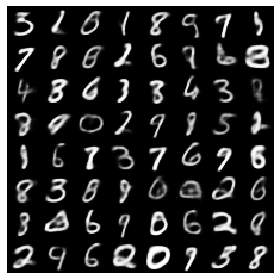

  5%|▍         | 46/1000 [1:02:37<21:38:53, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 2 we have for  0: 0.4999999888241291 and 

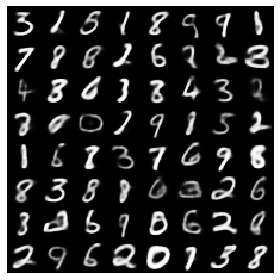

  5%|▍         | 47/1000 [1:03:59<21:37:33, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 1/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 101/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 401/590 and on k = 2 we have for  0: 0.5599999874830246 and 

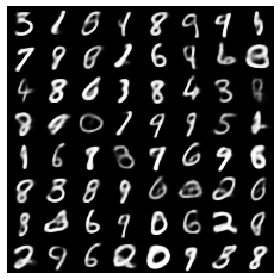

  5%|▍         | 48/1000 [1:05:21<21:36:14, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 1/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 2 we have for  0: 0.5799999870359898 a

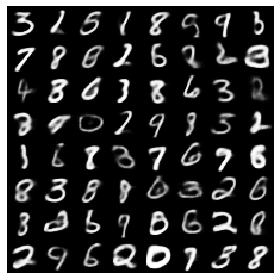

  5%|▍         | 49/1000 [1:06:43<21:35:39, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 1/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 301/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 2 we have for  0: 0.5599999874830246 and f

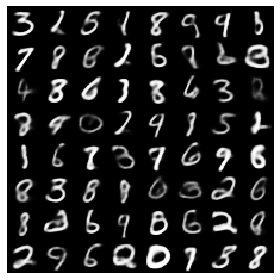

  5%|▌         | 50/1000 [1:08:04<21:34:31, 81.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 2 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 2 we have for  0: 0.3999999910593033 

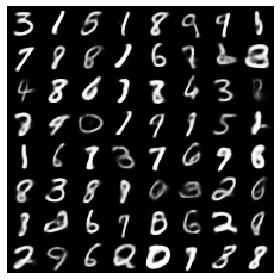

  5%|▌         | 51/1000 [1:09:26<21:33:09, 81.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 1/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.6299999859184027 and for +1: 0.36999999172985554
On batch number 301/590 and on k = 2 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.4599999897181988

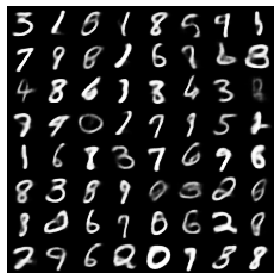

  5%|▌         | 52/1000 [1:10:48<21:31:28, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 401/590 and on k = 1 we have for  0: 0.3799999915063381 and for +1: 0.6199999861419201
On batch number 401/590 and on k = 2 we have for  0: 0.549999987706542 and

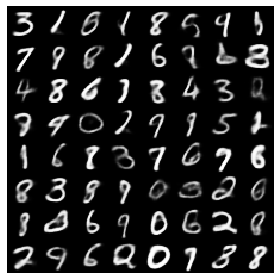

  5%|▌         | 53/1000 [1:12:09<21:29:46, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 1/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 2 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 301/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 401/590 and on k = 2 we have for  0: 0.4899999890476465

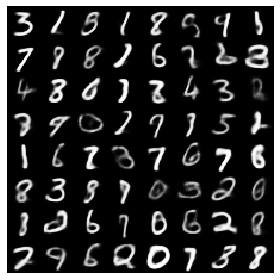

  5%|▌         | 54/1000 [1:13:31<21:28:10, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.3799999915063381 and for +1: 0.6199999861419201
On batch number 1/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 101/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 2 we have for  0: 0.4499999899417162 and

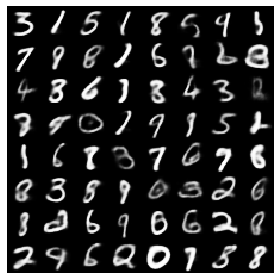

  6%|▌         | 55/1000 [1:14:53<21:26:56, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 2 we have for  0: 0.36999999172985554 and for +1: 0.6299999859184027
On batch number 201/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 2 we have for  0: 0.4599999897181988 an

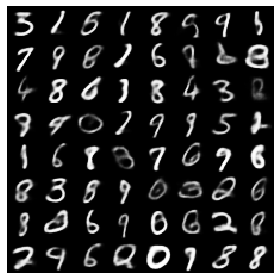

  6%|▌         | 56/1000 [1:16:15<21:25:28, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 1/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 301/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 2 we have for  0: 0.3799999915063381 a

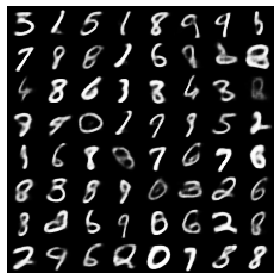

  6%|▌         | 57/1000 [1:17:36<21:23:54, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 1/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 2 we have for  0: 0.4499999899417162 an

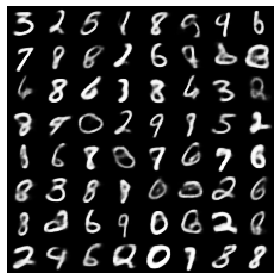

  6%|▌         | 58/1000 [1:18:58<21:22:42, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 1/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.5799999870359898 

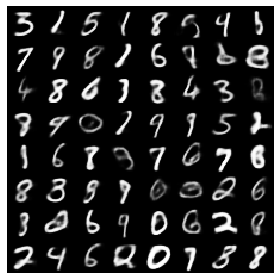

  6%|▌         | 59/1000 [1:20:20<21:21:57, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 1/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 2 we have for  0: 0.549999987706542 and 

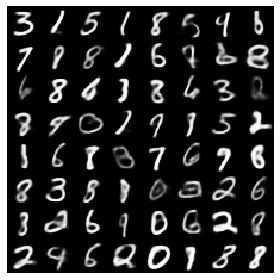

  6%|▌         | 60/1000 [1:21:42<21:20:51, 81.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 401/590 and on k = 2 we have for  0: 0.4499999899417162 

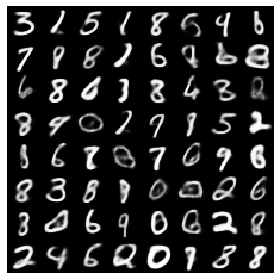

  6%|▌         | 61/1000 [1:23:03<21:19:03, 81.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 1/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 301/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.3899999912828207 and for +1: 0.6099999863654375
On batch number 401/590 and on k = 2 we have for  0: 0.4699999894946813

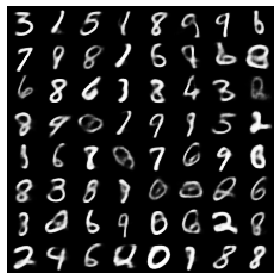

  6%|▌         | 62/1000 [1:24:25<21:17:20, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 1/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.6499999854713678 and for +1: 0.3499999921768904
On batch number 101/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 and

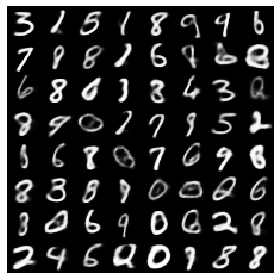

  6%|▋         | 63/1000 [1:25:47<21:15:43, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 201/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.46999998949468136 a

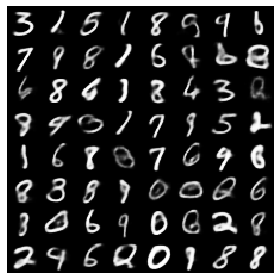

  6%|▋         | 64/1000 [1:27:08<21:14:24, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 2 we have for  0: 0.4999999888241291 and 

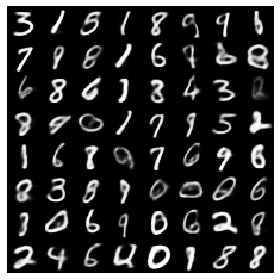

  6%|▋         | 65/1000 [1:28:30<21:13:19, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 401/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 2 we have for  0: 0.549999987706542 and f

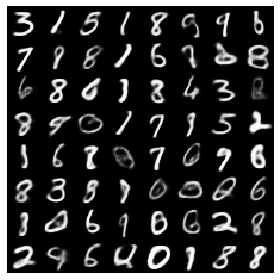

  7%|▋         | 66/1000 [1:29:52<21:11:51, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 101/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 2 we have for  0: 0.589999986812472

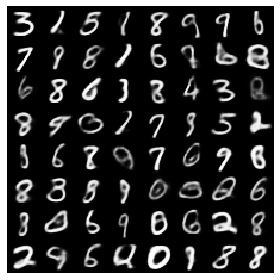

  7%|▋         | 67/1000 [1:31:13<21:10:19, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 1/590 and on k = 2 we have for  0: 0.6599999852478504 and for +1: 0.3399999924004078
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.6199999861419201 and for +1: 0.3799999915063381
On batch number 201/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 301/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 2 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 401/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 401/590 and on k = 2 we have for  0: 0.46999998949468136 and

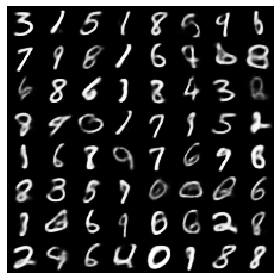

  7%|▋         | 68/1000 [1:32:35<21:08:57, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 101/590 and on k = 2 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 2 we have for  0: 0.4499999899417162 

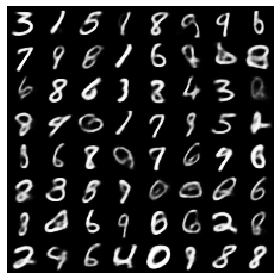

  7%|▋         | 69/1000 [1:33:57<21:08:05, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 1/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 2 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 201/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 301/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.6099999863654375 and for +1: 0.3899999912828207
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 

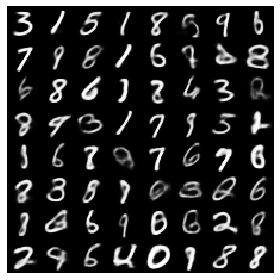

  7%|▋         | 70/1000 [1:35:19<21:07:09, 81.75s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 1/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 2 we have for  0: 0.5199999883770943 an

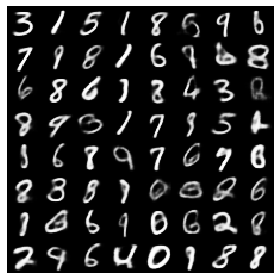

  7%|▋         | 71/1000 [1:36:40<21:05:39, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 1/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 201/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 201/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 1 we have for  0: 0.40999999083578587 and for +1: 0.5899999868124723
On batch number 301/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 

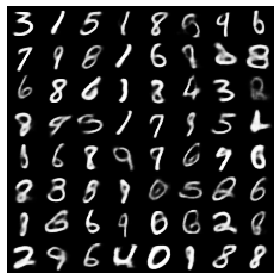

  7%|▋         | 72/1000 [1:38:02<21:03:57, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5699999872595072 and for +1: 0.42999999038875103
On batch number 1/590 and on k = 2 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 201/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 2 we have for  0: 0.5399999879300594 an

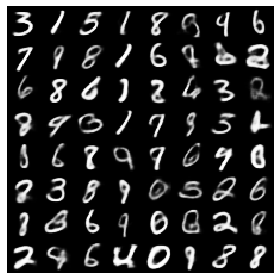

  7%|▋         | 73/1000 [1:39:24<21:02:22, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 2 we have for  0: 0.5199999883770943 and for

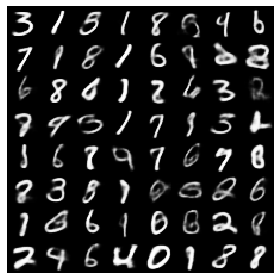

  7%|▋         | 74/1000 [1:40:45<21:01:10, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 1/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 101/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.47999998927116394 a

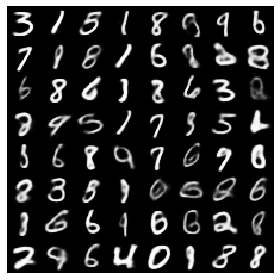

  8%|▊         | 75/1000 [1:42:07<20:59:54, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 1/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 201/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 2 we have for  0: 0.4599999897181988 and f

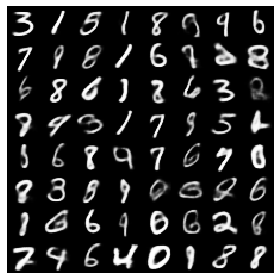

  8%|▊         | 76/1000 [1:43:29<20:58:18, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 101/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 201/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 301/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 2 we have for  0: 0.46999998949468136 and 

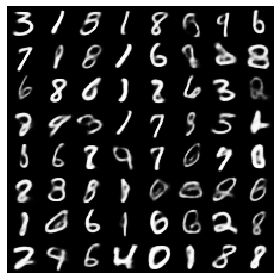

  8%|▊         | 77/1000 [1:44:51<20:56:46, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 1/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.3899999912828207 and for +1: 0.6099999863654375
On batch number 101/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 201/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 301/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 401/590 and on k = 2 we have for  0: 0.5099999886006117 and

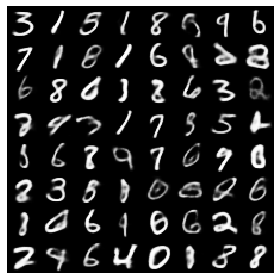

  8%|▊         | 78/1000 [1:46:12<20:55:19, 81.69s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 101/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 301/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 301/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 2 we have for  0: 0.40999999083578587 an

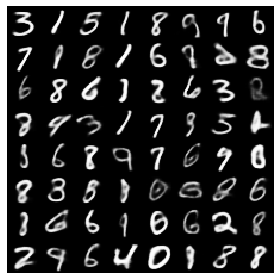

  8%|▊         | 79/1000 [1:47:34<20:54:32, 81.73s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 1/590 and on k = 2 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 101/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 101/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 201/590 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 201/590 and on k = 2 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 301/590 and on k = 1 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 301/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 1 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 2 we have for  0: 0.4899999890476465 an

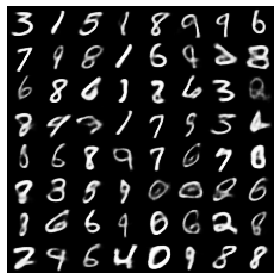

  8%|▊         | 80/1000 [1:48:56<20:53:43, 81.76s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 101/590 and on k = 2 we have for  0: 0.5799999870359898 and for +1: 0.41999999061226845
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 301/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 401/590 and on k = 2 we have for  0: 0.4999999888241291 and 

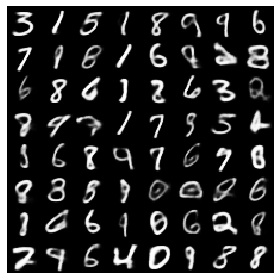

  8%|▊         | 81/1000 [1:50:18<20:52:01, 81.74s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 1/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 101/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 201/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 201/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 2 we have for  0: 0.4899999890476465 and for +1: 0.5099999886006117
On batch number 401/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 2 we have for  0: 0.4999999888241291 and for

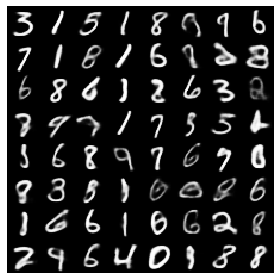

  8%|▊         | 82/1000 [1:51:39<20:50:19, 81.72s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 1/590 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 2 we have for  0: 0.6399999856948853 and for +1: 0.35999999195337296
On batch number 201/590 and on k = 1 we have for  0: 0.3999999910593033 and for +1: 0.5999999865889549
On batch number 201/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 1 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246
On batch number 301/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 401/590 and on k = 2 we have for  0: 0.5099999886006117 a

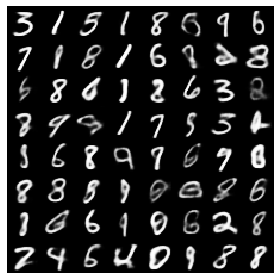

  8%|▊         | 83/1000 [1:53:01<20:48:46, 81.71s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 1/590 and on k = 2 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 101/590 and on k = 1 we have for  0: 0.5399999879300594 and for +1: 0.4599999897181988
On batch number 101/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 201/590 and on k = 1 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 201/590 and on k = 2 we have for  0: 0.549999987706542 and for +1: 0.4499999899417162
On batch number 301/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 301/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 401/590 and on k = 1 we have for  0: 0.5199999883770943 and for +1: 0.47999998927116394
On batch number 401/590 and on k = 2 we have for  0: 0.4999999888241291 and

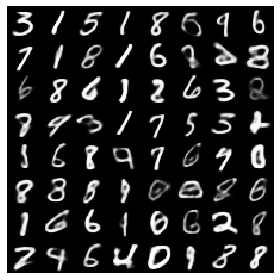

  8%|▊         | 84/1000 [1:54:23<20:47:18, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 1/590 and on k = 2 we have for  0: 0.42999999038875103 and for +1: 0.5699999872595072
On batch number 101/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 2 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 201/590 and on k = 2 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 301/590 and on k = 1 we have for  0: 0.5999999865889549 and for +1: 0.3999999910593033
On batch number 301/590 and on k = 2 we have for  0: 0.4499999899417162 and for +1: 0.549999987706542
On batch number 401/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 401/590 and on k = 2 we have for  0: 0.4899999890476465 and 

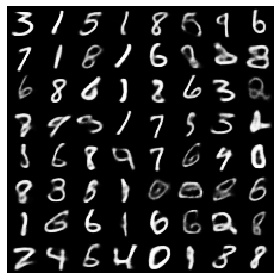

  8%|▊         | 85/1000 [1:55:44<20:45:53, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 1/590 and on k = 2 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 101/590 and on k = 1 we have for  0: 0.5899999868124723 and for +1: 0.40999999083578587
On batch number 101/590 and on k = 2 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 1 we have for  0: 0.47999998927116394 and for +1: 0.5199999883770943
On batch number 201/590 and on k = 2 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 301/590 and on k = 1 we have for  0: 0.46999998949468136 and for +1: 0.5299999881535769
On batch number 301/590 and on k = 2 we have for  0: 0.41999999061226845 and for +1: 0.5799999870359898
On batch number 401/590 and on k = 1 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 401/590 and on k = 2 we have for  0: 0.579999987035989

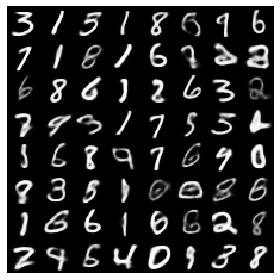

  9%|▊         | 86/1000 [1:57:06<20:44:29, 81.70s/it]

On batch number 1/590 and on k = 1 we have for  0: 0.5099999886006117 and for +1: 0.4899999890476465
On batch number 1/590 and on k = 2 we have for  0: 0.4999999888241291 and for +1: 0.4999999888241291
On batch number 101/590 and on k = 1 we have for  0: 0.4599999897181988 and for +1: 0.5399999879300594
On batch number 101/590 and on k = 2 we have for  0: 0.4399999901652336 and for +1: 0.5599999874830246


In [ ]:
print_info_ = 1
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

best_elbo = -float("inf")
current_elbo_val = -float("inf")

current_tolerance = 0
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        target.decoder.train()
        plt.close()        

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        if ep < args.vanilla_vae_epoches:
            log_p = target.get_logdensity(z=z, x=batch_train)
            log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo_full = torch.mean(log_p - log_m)
            (-elbo_full).backward()
            optimizer_vanilla.step()
            optimizer_vanilla.zero_grad()
            if b_num == (args.train_batch_size - 1):
                args.train_batch_size = batch_size
                dataset = Dataset(args, device=args.device)
        else:
            target.train()
            p_old = args.std_normal.sample(z.shape)
            cond_vectors = [args.std_normal.sample(p_old.shape) for k in range(args.K)]

            sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
            sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
            p = p_old
            if args.learnable_reverse:
                all_directions = torch.tensor([], device=args.device)
            else:
                all_directions = None
            for k in range(args.K):
                # sample alpha - transition probabilities 
                if args.amortize:
#                     pdb.set_trace()
                    z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                        p_old=p, k=cond_vectors[k], target_distr=target, args=args, get_prior=get_prior, prior_flow=prior_flow)
                else:
                    z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                        p_old=p, k=cond_vectors[k], target_distr=target, args=args, get_prior=get_prior, prior_flow=prior_flow) # sample a_i -- directions
                if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                    print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                            dataset.train.shape[0] // args['train_batch_size'],
                                                                               k + 1,
                                                        (directions==0.).to(float).mean(),
                                                                        (directions==1.).to(float).mean()))
                    if args.amortize:
                        print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                        print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
                if args.learnable_reverse:
                    all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
                # Accumulate alphas
                sum_log_alpha = sum_log_alpha + current_log_alphas
                sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
            ##############################################
            if args.hoffman_idea:
                if args.learnable_reverse:
                    log_r = reverse_kernel(z_fin=z.detach(), mu=mu.detach(), a=all_directions)
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha
                else:
                    log_r = 0 #-args.K * torch_log_2
                    log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma # + sum_log_alpha
                log_p = target.get_logdensity(z=z, x=batch_train, prior=get_prior, args=args, prior_flow=prior_flow) + args.std_normal.log_prob(p.sum(1))
                elbo_full = log_p + log_r - log_m
#                 pdb.set_trace()
                ### Gradient of the first objective:
                target.eval()
                obj_1 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
                (-obj_1).backward(retain_graph=True)
                optimizer_inference.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad() 
                
                ### Gradient of the second objective:
                target.train()
                log_p = target.get_logdensity(z=z.detach(), x=batch_train, prior=get_prior, args=args, prior_flow=prior_flow) + args.std_normal.log_prob(p.detach()).sum(1)
                elbo_full = log_p - log_m
                obj_2 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
                (-obj_2).backward()
                optimizer.step()
                optimizer_inference.zero_grad()
                optimizer.zero_grad()
            ###########################################################
            else:
                elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                    sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu,
                                                    all_directions=all_directions, get_prior=get_prior, args=args, prior_flow=prior_flow)
                (-grad_elbo).backward()
            if args.clip_norm:
                torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
                
            if args.separate_params: # if we separate params of inference part and generation part
                optimizer_inference.step() # we always perform step for inference part
                if (ep - args.vanilla_vae_epoches) % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                    optimizer.step()
                optimizer.zero_grad()
                optimizer_inference.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
    ###### validation ######
    target.decoder.eval()
#             pdb.set_trace()
    current_elbo_val = validate_vae(args=args, encoder=encoder, target=target, transitions=transitions, dataset=dataset, get_prior=get_prior, prior_flow=prior_flow)
    if (current_elbo_val != current_elbo_val).sum():
        print('NAN appeared!')
        raise ValueError
    if current_elbo_val > best_elbo:
        current_tolerance = 0
        best_elbo = current_elbo_val
        if not os.path.exists('./models/{}/'.format(args.data)):
            os.makedirs('./models/{}/'.format(args.data))
        torch.save(encoder,
            './models/{}/best_encoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}_nfprior_{}_numnfpriors_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder, args.nf_prior, args.num_flows_prior))
        torch.save(target.decoder,
            './models/{}/best_decoder_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}_nfprior_{}_numnfpriors_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder, args.nf_prior, args.num_flows_prior))
        torch.save(transitions,
            './models/{}/best_transitions_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}_nfprior_{}_numnfpriors_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder, args.nf_prior, args.num_flows_prior))
        if args.learnable_reverse:
            torch.save(reverse_kernel,
            './models/{}/best_reverse_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}_nfprior_{}_numnfpriors_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder, args.nf_prior, args.num_flows_prior))
        if args.num_flows_prior:
            torch.save(prior_flow,
            './models/{}/best_priorflow_data_{}_K_{}_N_{}_fixtransition_{}_amortize_{}_learnreverse_{}_vanillaepoches_{}_hoffmanlike_{}_separateparams_{}_usebatchnorm_{}_decoder_{}_nfprior_{}_numnfpriors_{}.pt'.format(args.data,
                                    args.data, args.K, args.N, args.fix_transition_params, args.amortize, args.learnable_reverse, args.vanilla_vae_epoches,
                                                                                                args.hoffman_idea, args.separate_params, args.use_batchnorm, args.decoder, args.nf_prior, args.num_flows_prior))

    else:
        current_tolerance += 1
        if current_tolerance >= args.early_stopping_tolerance:
            print("Early stopping on epoch {} (effectively trained for {} epoches)".format(ep,
                                              ep - args.early_stopping_tolerance))
            break
                
    if ep % print_info_ == 0:
        target.decoder.eval()
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO train:', elbo_full.detach().mean().item())
        print('Best elbo validation', best_elbo)
        print('Current elbo validation', current_elbo_val)
        
        rand_code = random_code
        if prior_flow:
            for p in prior_flow.parameters():
                p.requires_grad_(False)
            for pflow in prior_flow:
                rand_code = pflow._inverse(rand_code)
            for p in prior_flow.parameters():
                p.requires_grad_(True)
        plot_digit_samples(samples=get_samples(target.decoder, rand_code), args=args, epoch=ep)

In [ ]:
print(best_elbo)

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [ ]:
dataset = Dataset(args, device=args.device)

In [ ]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [ ]:
print_info_ = 10

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

In [ ]:
target.decoder.linear1.bias